# 1. Classifier Performance Comparison.

In [09_2_lsa_demo_with_classifier_performance.ipynb] we demonstrated how to classify Reuters articles as acquisition-related by using a K-nn classifier on 
* (A) the TF-IDF vectorized Reuters dataset 
* (B) an LSA-enhanced TF-IDF vectorized Reuters dataset where the LSA vectors of the top 200 components were concatenated with the TF-IDF vectors. 

We compared the classifier performance of the A and B flavors of each K-nn model by calculating the ROC and precision recall curves.


## (a) Pipeline all of this functionality in a single Scikit-Learn ``ReutersClassifier`` model.
The model parameters should be:
* ``num_lsa_components`` which should be an integer between 0 and 500 corresponding to the number of LSA components concatenating the TF-IDF vectorization of the input data. The default should be 0 corresponding to pure TF-IDF vectorization.
* ``n_neighbors`` which should be an integer between 0 and 20 corresponding to the number of nearest neighbors used in the ``KNeighborsClassifier``

##### Read Data and Split:

In [1]:
def Original_Label_Split(label):
    import pickle
    import os
    fname = "raw_text_dataset.pickle"
    filepath = os.getcwd() + '/' + fname
    raw_text_dataset = pickle.load(open(filepath, "rb"))
    X_train, labels_train = raw_text_dataset[0], raw_text_dataset[1] 
    X_test, labels_test = raw_text_dataset[2], raw_text_dataset[3]

    y_train = [label in y for y in labels_train]
    y_test = [label in y for y in labels_test]
    return (X_train, y_train, X_test, y_test)

X_train_acq, y_train_acq, X_test_acq, y_test_acq = Original_Label_Split(label = 'acq')

##### ReutersClassifier:

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import pickle
import os


class ReutersClassifier(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, n_neighbors: int, num_lsa_components = 0):
        '''
        Args
        ----------
        num_lsa_components: integer between 0 and 500 
            the number of LSA components concatenating the TF-IDF vectorization 
            of the input data. 
            The default is 0 corresponding to pure TF-IDF vectorization.
            
        n_neighbors: integer between 0 and 20 
            the number of nearest neighbors used in the KNeighborsClassifier
            
        '''
        if num_lsa_components < 0 or num_lsa_components > 500:
            raise ValueError('num_lsa_components should be an integer between 0 and 500!')
        else:
            self.num_lsa_components = num_lsa_components
            
        if n_neighbors <= 0 or n_neighbors > 20:
            raise ValueError('n_neighbors should be an integer between 0 and 20!')
        else:
            self.n_neighbors = n_neighbors
        
        self.vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, min_df=2, 
                                     stop_words='english', norm='l2', use_idf=True, 
                                     analyzer='word', token_pattern = '(?u)\\b[a-zA-Z]\\w+\\b')
        if num_lsa_components != 0:
            svd = TruncatedSVD(n_components=self.num_lsa_components, random_state=42, algorithm='arpack')
            self.lsa = make_pipeline(svd)
        
        self.knn = KNeighborsClassifier(n_neighbors=self.n_neighbors, algorithm='brute', metric='cosine')
        
    def fit(self, X, y): # Corpus_train, y_train
        self.classes_ = np.unique(y)
        self.X_train_tfidf = self.vectorizer.fit_transform(X)
        
        if self.num_lsa_components == 0:
            self.knn.fit(self.X_train_tfidf, y)
            return self
        else:
            self.X_train_lsa = self.lsa.fit_transform(self.X_train_tfidf)
            #self.knn.fit(np.c_[X_train_lsa,X_train_tfidf.toarray()], y)
            self.knn.fit(self.X_train_lsa, y)
            return self
        
    def transform(self, X, y=None): # X_test y_test
        X_test_tfidf = self.vectorizer.transform(X)
        
        if self.num_lsa_components == 0:
            return self.knn.predict(X_test_tfidf)
        else:
            X_test_lsa = self.lsa.transform(X_test_tfidf)
            #return self.knn.predict(np.c_[X_test_lsa, X_test_tfidf.toarray()])
            return self.knn.predict(X_test_lsa)
        
    def predict(self, X, y=None):
        return self.transform(X)
        
    def get_params(self, deep=True):
        return {"num_lsa_components": self.num_lsa_components, "n_neighbors": self.n_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def predict_proba(self, X):
        pred = np.random.rand(X.shape[0], self.classes_.size)
        return pred / np.sum(pred, axis=1)[:, np.newaxis]

##### Example:

In [3]:
def Conducting_Classifisication(input_data: tuple, n_neighbors = 5, num_lsa_components = 200):
    
    X_train, y_train, X_test, y_test = input_data[0], input_data[1], input_data[2], input_data[3]
    
    clfer = ReutersClassifier(n_neighbors, num_lsa_components)
    results = clfer.fit(X_train, y_train).transform(X_test)

    # Measure accuracy
    numRight = 0;
    for i in range(0,len(results)):
        if results[i] == y_test[i]:
            numRight += 1
    print("  (%d / %d) correct on test set - %.2f%%" % (numRight, len(y_test), 
                                            float(numRight) / float(len(y_test)) * 100.0))

input_tuple_acq = (X_train_acq, y_train_acq, X_test_acq, y_test_acq)
Conducting_Classifisication(input_data=input_tuple_acq, n_neighbors = 5, num_lsa_components = 200)    

  (4552 / 4858) correct on test set - 93.70%


## (b) For each of the following target labels 
* (1) ‘earn’ 
* (2) ‘usa’ 
* (3) ‘corn’ 
create a train and test set of the articles which are tagged with a given label or not. 

Should you use stratified shuffle split for any of these variables, and if yes for which ones?



In [4]:
print('Reload FULL datasets ...')
fname = "raw_text_dataset.pickle"
filepath = os.getcwd() + '/' + fname
raw_text_dataset = pickle.load(open(filepath, "rb"))
X_train, labels_train, X_test, labels_test = raw_text_dataset[0], raw_text_dataset[1], raw_text_dataset[2], raw_text_dataset[3]

# combine original datasets
X_full = np.array(X_test+X_train)
label_full = labels_test+labels_train
print('Prepared: X_full & label_full.')

Reload FULL datasets ...
Prepared: X_full & label_full.


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def MyStratifiedShuffleSplit(label):
    print('-----Target Label: ', label, '-----')
    y_full = np.array([label in y for y in label_full])

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(X_full, y_full):
        X_train_strat = X_full[train_index]
        y_train_strat = y_full[train_index]

        X_test_strat = X_full[test_index]
        y_test_strat = y_full[test_index]

    print('Train set:',sum(y_train_strat),'label-related articles, or',
          round(sum(y_train_strat)/len(y_train_strat)*100,2),'percent')

    print('Test set:',sum(y_test_strat),'label-related articles, or',
          round(sum(y_test_strat)/len(y_test_strat)*100,2),'percent')

    print('Full set:',sum(y_train_strat)+sum(y_test_strat),'label-related articles, or',
          round((sum(y_train_strat)+sum(y_test_strat))/(len(y_train_strat)+len(y_test_strat))*100,2),
          'percent\n')
    return (X_train_strat, y_train_strat, X_test_strat, y_test_strat)

In [6]:
labels = ['earn','usa','corn']
splits = []
for l in labels:
    splits.append(MyStratifiedShuffleSplit(l))

-----Target Label:  earn -----
Train set: 1778 label-related articles, or 23.15 percent
Test set: 445 label-related articles, or 23.17 percent
Full set: 2223 label-related articles, or 23.15 percent

-----Target Label:  usa -----
Train set: 4866 label-related articles, or 63.36 percent
Test set: 1217 label-related articles, or 63.35 percent
Full set: 6083 label-related articles, or 63.36 percent

-----Target Label:  corn -----
Train set: 109 label-related articles, or 1.42 percent
Test set: 27 label-related articles, or 1.41 percent
Full set: 136 label-related articles, or 1.42 percent



In [7]:
input_tuple_earn = splits[0]
input_tuple_usa = splits[1]
input_tuple_corn = splits[2]
for abl, tpl in zip(labels,splits):
    print('After re-split for ['+abl+'] ...')
    Conducting_Classifisication(tpl, n_neighbors=5, num_lsa_components = 200)

After re-split for [earn] ...
  (1875 / 1921) correct on test set - 97.61%
After re-split for [usa] ...
  (1698 / 1921) correct on test set - 88.39%
After re-split for [corn] ...
  (1906 / 1921) correct on test set - 99.22%


## (c) Using ``GridSearchCV`` find the optimal ``num_lsa_components`` and ``n_neighbors`` for each of the training datasets (1)-(3) above. Use ‘f1’ a score evaluation metric. 

In [8]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

predictor = ReutersClassifier(n_neighbors=5)
param_grid = [
    {
        'num_lsa_components': [0,100,200,300,500],
        'n_neighbors': [1,5,10,20]
    },
  ]
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='f1')

# for 'earn' split tuple 
# splits[0] =  (train_X_strat, train_y_strat, test_X_strat, test_y_strat)
for abl, tpl in zip(labels,splits):
    print('GridSearching with f1 after re-split for ['+abl+'] ...')
    grid_search.fit(tpl[0], tpl[1])
    print(grid_search.best_estimator_)

GridSearching with f1 after re-split for [earn] ...
ReutersClassifier(n_neighbors=1, num_lsa_components=0)
GridSearching with f1 after re-split for [usa] ...
ReutersClassifier(n_neighbors=1, num_lsa_components=0)
GridSearching with f1 after re-split for [corn] ...
ReutersClassifier(n_neighbors=1, num_lsa_components=0)


## Plot the ROC and Precision-Recall (PR) curves for the optimal parameter. 

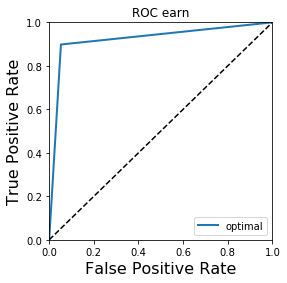

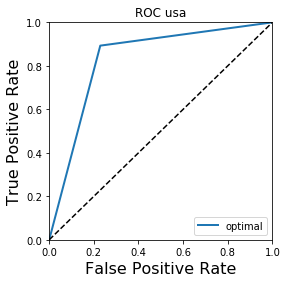

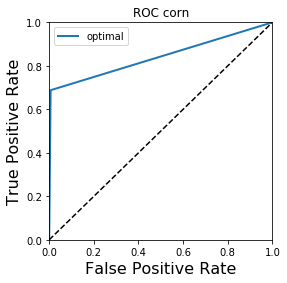

In [9]:
# ROC
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

def plot_roc_curve(ax, fpr, tpr, target: str, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    if label is not None:
        ax.legend()
    ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC '+target)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

def ROC_generator(input_tuple: tuple, target: str, 
                  optimal_n_neighbors, optimal_num_lsa_components):
    
    
    RC_Optimal = ReutersClassifier(n_neighbors=optimal_n_neighbors, 
                                 num_lsa_components = optimal_num_lsa_components)
    
    X_train_earn = input_tuple[0]
    y_train_earn = input_tuple[1]
    RC_Optimal.fit(X_train_earn, y_train_earn)
    models = {'optimal': RC_Optimal.knn}
    
    if optimal_num_lsa_components == 0:
        features_train = {'optimal': RC_Optimal.X_train_tfidf}
    else:
        features_train = {'optimal':RC_Optimal.X_train_lsa}

    for i, mname in enumerate(models.keys()):
        p_scores = cross_val_predict(models[mname], features_train[mname], 
                                     y_train_earn, cv=10, method="predict_proba")
        if p_scores.ndim == 2:
            p_scores = p_scores[:, 1]

        fpr, tpr, thresholds = roc_curve(y_train_earn, p_scores)

        if i == 0:
            fig, ax = plt.subplots(1,1, figsize=(4,4))
        plot_roc_curve(ax, fpr, tpr, target = target,label=mname)

    plt.show()

for tup, tgt in zip(splits, labels):
    ROC_generator(tup, tgt, optimal_n_neighbors=1, optimal_num_lsa_components=0)

##### PR curve:

RC Model: f1=0.864 auc=0.227


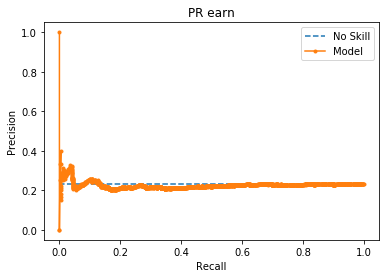

RC Model: f1=0.890 auc=0.638


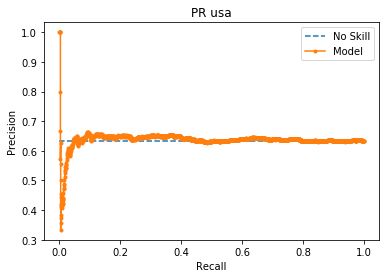

RC Model: f1=0.667 auc=0.021


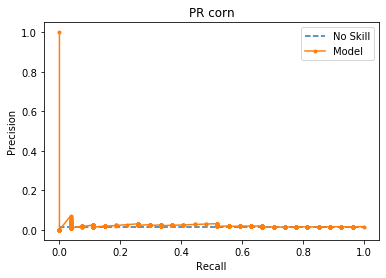

In [10]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

def PR_generator(input_tuple: tuple, target: str, 
                  optimal_n_neighbors, optimal_num_lsa_components):
    
    trainX, testX, trainy, testy = input_tuple[0], input_tuple[2], input_tuple[1], input_tuple[3]

    RC_Optimal = ReutersClassifier(n_neighbors=optimal_n_neighbors, 
                                     num_lsa_components = optimal_num_lsa_components)

    RC_Optimal.fit(trainX, trainy)

    # predict probabilities
    lr_probs = RC_Optimal.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = RC_Optimal.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('RC Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Model')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title('PR '+target)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

for tup, tgt in zip(splits, labels):
    PR_generator(tup, tgt, optimal_n_neighbors=1, optimal_num_lsa_components=0)

## Repeat your analysis but use the ‘roc_auc’ score. Compare the ROC and PR curves for each of the two optimal models. Discuss your results.

In [11]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

predictor = ReutersClassifier(n_neighbors=5)
param_grid = [
    {
        'num_lsa_components': [0,100,200,300,500],
        'n_neighbors': [1,5,10,20]
    },
  ]
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='roc_auc')

# for 'earn' split tuple 
# splits[0] =  (train_X_strat, train_y_strat, test_X_strat, test_y_strat)
for abl, tpl in zip(labels,splits):
    print('GridSearching with ROC_AUC after re-split for ['+abl+'] ...')
    grid_search.fit(tpl[0], tpl[1])
    print('     Optimal RC is',grid_search.best_estimator_)

GridSearching with ROC_AUC after re-split for [earn] ...
     Optimal RC is ReutersClassifier(n_neighbors=1, num_lsa_components=0)
GridSearching with ROC_AUC after re-split for [usa] ...
     Optimal RC is ReutersClassifier(n_neighbors=5, num_lsa_components=0)
GridSearching with ROC_AUC after re-split for [corn] ...
     Optimal RC is ReutersClassifier(n_neighbors=5, num_lsa_components=0)


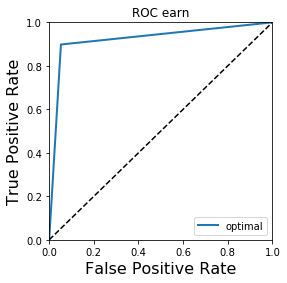

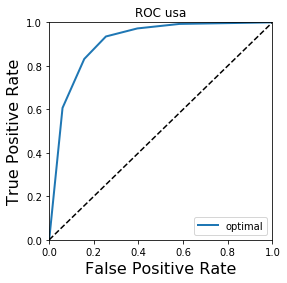

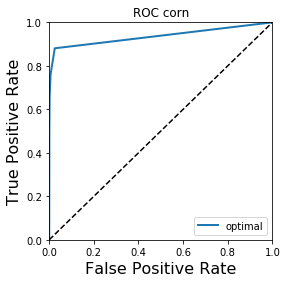

In [12]:
optimal_params = [[1,0],[5,0],[5,0]]
for tup, tgt, params in zip(splits, labels, optimal_params):
    ROC_generator(tup, tgt, optimal_n_neighbors=params[0], optimal_num_lsa_components=params[1])

RC Model: f1=0.864 auc=0.221


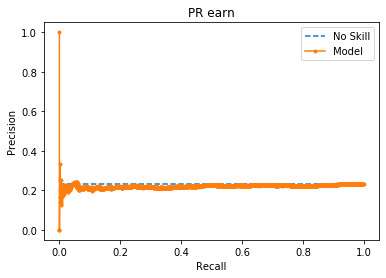

RC Model: f1=0.907 auc=0.637


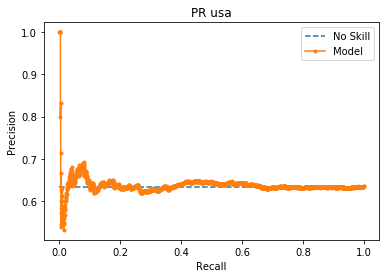

RC Model: f1=0.720 auc=0.020


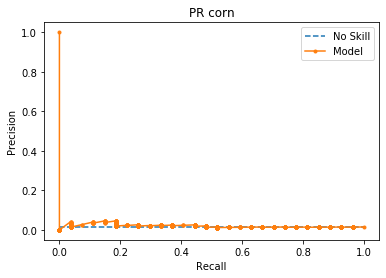

In [13]:
for tup, tgt, params in zip(splits, labels, optimal_params):
    PR_generator(tup, tgt, optimal_n_neighbors=params[0], optimal_num_lsa_components=params[1])